<a href="https://colab.research.google.com/github/entc-17-fyp-20/WPF_Data_Visualization/blob/Kusal/GRU_Multi_step_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from collections import UserDict
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
%matplotlib inline
import plotly.express as px
import io


pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

url1 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/S6%2010%20seconed%20data.csv' #S6 10 seconed data.csv
url2 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/AE59_1.csv' #AE59_1
url3 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/AE59_2.csv' #AE59_2
url4 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V08%20June%2010%20sec%20data.csv' #V08 June 10 sec data.csv; does not contain current columns
url5 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20June%2010%20sec%20data.csv' #V13 June 10 sec data.csv
url6 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V08%20July%2010%20sec%20data.csv' #V08 July 10 sec data.csv
url7 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20July%2010%20sec%20data.csv' #V13 July 10 sec data.csv
url8 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/Mannar.csv'  #Mannar dataset-10_min-wind_speed.csv
url9 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/Mannar%20full%20data.csv' #Mannar full data set.csv
df = pd.read_csv(url9)

In [3]:
df_features=df.copy()
df_features.drop(df_features.columns[[0,4]], axis = 1, inplace = True)
df_features

,Average Wind Speed (m/s),Average Wind Dirction (deg),Average Active Power (MW)
0,10.66,186.92,95.84
1,10.71,188.15,96.03
2,10.53,188.78,93.72
3,10.20,189.80,88.84
4,10.34,193.00,90.97
...,...,...,...
4404,11.62,195.08,100.45
4405,11.16,196.36,98.01
4406,10.66,198.02,93.11
4407,10.90,196.96,93.68


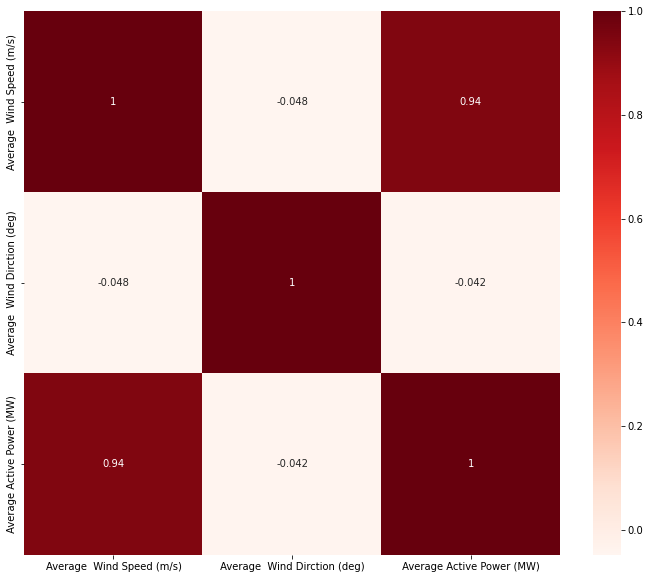

In [4]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df_features.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [5]:
#Correlation with output variable
cor_target = abs(cor[" Average Active Power (MW) "])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.8]
relevant_features

Average  Wind Speed (m/s)     0.94
 Average Active Power (MW)    1.00
Name:  Average Active Power (MW) , dtype: float64

In [6]:
df=df.set_index('Date & Time')
df

,Average Wind Speed (m/s),Average Wind Dirction (deg),Average Active Power (MW),Forecasted Power (kW)
Date & Time,,,,
8/1/2021 0:00,10.66,186.92,95.84,100.25
8/1/2021 0:10,10.71,188.15,96.03,100.01
8/1/2021 0:20,10.53,188.78,93.72,97.12
8/1/2021 0:30,10.20,189.80,88.84,96.96
8/1/2021 0:40,10.34,193.00,90.97,94.08
...,...,...,...,...
8/31/2021 23:20,11.62,195.08,100.45,101.74
8/31/2021 23:30,11.16,196.36,98.01,101.78
8/31/2021 23:40,10.66,198.02,93.11,101.85


In [15]:
df_new=df[['Average  Wind Speed (m/s)',' Average Active Power (MW) ']]
df_new

,Average Wind Speed (m/s),Average Active Power (MW)
Date & Time,,
8/1/2021 0:00,10.66,95.84
8/1/2021 0:10,10.71,96.03
8/1/2021 0:20,10.53,93.72
8/1/2021 0:30,10.20,88.84
8/1/2021 0:40,10.34,90.97
...,...,...
8/31/2021 23:20,11.62,100.45
8/31/2021 23:30,11.16,98.01
8/31/2021 23:40,10.66,93.11


In [16]:
df.describe()

,Average Wind Speed (m/s),Average Wind Dirction (deg),Average Active Power (MW),Forecasted Power (kW)
count,"4,409.00","4,409.00","4,409.00","4,409.00"
mean,9.95,197.37,72.60,72.22
std,2.59,14.21,31.06,29.21
min,1.81,130.84,-0.76,1.83
25%,8.22,189.00,48.45,45.45
50%,10.06,194.74,84.46,79.70
75%,11.88,203.61,100.99,100.57
max,16.45,311.14,103.42,103.39


In [17]:
L=len(df)
valid_start=int(18*L/20)
test_start=int(19*L/20)

T = 6
HORIZON = 1

In [19]:
train=df_new[:valid_start]
train

,Average Wind Speed (m/s),Average Active Power (MW)
Date & Time,,
8/1/2021 0:00,10.66,95.84
8/1/2021 0:10,10.71,96.03
8/1/2021 0:20,10.53,93.72
8/1/2021 0:30,10.20,88.84
8/1/2021 0:40,10.34,90.97
...,...,...
8/28/2021 21:50,14.26,102.77
8/28/2021 22:00,14.00,102.55
8/28/2021 22:10,13.36,102.22


# **Scale data to be in range (0,1)**

In [21]:
from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()
y_scaler.fit(train[[' Average Active Power (MW) ']])

X_scaler = MinMaxScaler()
train[['Average  Wind Speed (m/s)',' Average Active Power (MW) ']] = X_scaler.fit_transform(train)

In [24]:
!pip common.utils
from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

tensor_structure = {'X':(range(-T+1, 1), ['Average  Wind Speed (m/s)',' Average Active Power (MW) '])}
train_inputs = TimeSeriesTensor(train, ' Average Active Power (MW) ', HORIZON, {'X':(range(-T+1, 1), ['Average  Wind Speed (m/s)',' Average Active Power (MW) '])})

ERROR: unknown command "common.utils"


ModuleNotFoundError: ignored